In [13]:
import pandas as pd
import numpy as np
#import json
import folium
import requests

In [14]:
!pip install geocoder geopandas

In [15]:
import geocoder
import geopandas

In [16]:
pd.options.display.max_columns=999
pd.options.display.max_rows=999


### Links list  to include into report

1. Crime rate: https://www.opendataphilly.org/dataset/crime-incidents
2. Geodata: https://github.com/azavea/geo-data/tree/master/Neighborhoods_Philadelphia
3. Foursquare API 
  
   


In [17]:
df = pd.read_csv('incidents_part1_part2.csv')
df['dispatch_date_time'] = pd.to_datetime(df['dispatch_date_time'])
cols = ['dispatch_date_time','location_block','text_general_code','lat','lng']
df = df[cols]
df['text_general_code'] = df['text_general_code'].astype('category')
df.to_pickle('incidents_db.pkl')

In [26]:
df = pd.read_pickle('incidents_db.pkl')

In [27]:
df.head(2)

,dispatch_date_time,location_block,text_general_code,lat,lng
0,2009-04-06 18:26:00,300 BLOCK E WALNUT LN,Burglary Residential,40.045752,-75.173378
1,2009-04-12 19:09:00,300 BLOCK E WALNUT LN,Burglary Residential,40.045752,-75.173378


In [28]:
import geopandas as gpd
phila_hoods = gpd.read_file('Neighborhoods_Philadelphia.geojson')

In [29]:
g = geocoder.arcgis('Philadelphia,US')
if g.ok:
    phila_lat = g.lat
    phila_lng = g.lng
else:
    print ('Unable resolve Philadelphia coordinates')

In [30]:
phila_map = folium.Map(
    location=[phila_lat,phila_lng], zoom_start=12)
folium.GeoJson(
    phila_hoods,
    name = 'Neighborhoods',
).add_to(phila_map)
phila_map

In [31]:
## function to calculate whether lat,lng coordinates belong to within neighboorhood

# The following code is borrowed from 
# https://github.com/craigmbooth/chicago_neighborhood_finder/blob/master/chicago_community_areas.py

def point_inside_polygon(lat,lng,poly):
    """Return True if the point described by x, y is inside of the polygon
    described by the list of points [(x0, y0), (x1, y1), ... (xn, yn)] in
    ``poly``
    Code from http://www.ariel.com.au/a/python-point-int-poly.html which
    in turn was adapted from C code found at
    http://local.wasp.uwa.edu.au/~pbourke/geometry/insidepoly/
    """
    n = len(poly)
    inside =False

    p1x,p1y = poly[0]
    for i in range(n+1):
        p2x,p2y = poly[i % n]
        if lat > min(p1y,p2y):
            if lat <= max(p1y,p2y):
                if lng <= max(p1x,p2x):
                    if p1y != p2y:
                        xinters = (lat-p1y)*(p2x-p1x)/(p2y-p1y)+p1x
                    if p1x == p2x or lng <= xinters:
                        inside = not inside
        p1x,p1y = p2x,p2y

    return inside

In [32]:
def get_hood(row):
    crime_x = row['lat']
    crime_y = row['lng']
#     crime_x = row.lat
#     crime_y = row.lng
    if row.name % 10000 == 0:
        print ('Processing {} row'.format(row.name))
    for hood in phila_hoods['features']:
        hood_name = hood['properties']['name']
        hood_coords = hood['geometry']['coordinates']
        if point_inside_polygon(crime_x,crime_y, hood_coords[0][0]):
            return hood_name
    return ("No hood match")
    

In [33]:
## the following code took almost 8 hours to execute on searching for all 2.6M rows for neighrboorhoods,
## so don't repeat w/o need.

#df['Neighborhood'] = df.apply(get_hood, axis=1)
#df.to_pickle('incident_with_neighboors.pkl')
## instead load processed file

df = pd.read_pickle('incident_with_neighboors.pkl')

In [35]:
## create a dictionary with coordinates for each neighboorhood
hood_coords = {}
for hood in df['Neighborhood'].unique():
    g = geocoder.arcgis('{},Philadelphia,US'.format(hood))
    if g.ok:
        hood_coords[hood] = {}
        hood_coords[hood]['lat'] = g.lat
        hood_coords[hood]['lng'] = g.lng
    else:
        hood_coords[hood] = 'No data'

In [36]:
## check if no data is present
for k in hood_coords.keys():
    if len(hood_coords[k])<2:
        print ('The following neighborhood has no data'.format(k))

In [37]:
# load Foursquare API and get info about neighborhoods similar to 
# to course approach
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT=50
def getNearbyVenues(hoods_data, radius=500):
    """
    hoods_data is dict format dict[hood]['lat'|'lng']
    """
    venues_list =[]
    for hood in hoods_data:
        print ('Proceesing neighborhood: {}'.format(hood))
        lat = hoods_data[hood]['lat']
        lng = hoods_data[hood]['lng']
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            hood, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])
        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [40]:
phila_venues = getNearbyVenues(hood_coords)

Proceesing neighborhood: GERMANTOWN_MORTON
Proceesing neighborhood: OXFORD_CIRCLE
Proceesing neighborhood: SPRING_GARDEN
Proceesing neighborhood: GRAYS_FERRY
Proceesing neighborhood: HOLMESBURG
Proceesing neighborhood: WASHINGTON_SQUARE
Proceesing neighborhood: AIRPORT
Proceesing neighborhood: FELTONVILLE
Proceesing neighborhood: NORTHERN_LIBERTIES
Proceesing neighborhood: INDUSTRIAL
Proceesing neighborhood: WEST_KENSINGTON
Proceesing neighborhood: FISHTOWN
Proceesing neighborhood: OLD_KENSINGTON
Proceesing neighborhood: LOGAN
Proceesing neighborhood: MAYFAIR
Proceesing neighborhood: LOWER_MOYAMENSING
Proceesing neighborhood: FRANKLINVILLE
Proceesing neighborhood: EAST_PARKSIDE
Proceesing neighborhood: HADDINGTON
Proceesing neighborhood: GIRARD_ESTATES
Proceesing neighborhood: FRANKFORD
Proceesing neighborhood: KINGSESSING
Proceesing neighborhood: STRAWBERRY_MANSION
Proceesing neighborhood: SOCIETY_HILL
Proceesing neighborhood: NORTH_CENTRAL
Proceesing neighborhood: FERN_ROCK
Proceesin

In [44]:
phila_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,GERMANTOWN_MORTON,40.029670,-75.17531,Chelten Market,40.031777,-75.177593,Market
1,GERMANTOWN_MORTON,40.029670,-75.17531,Trio's Breakfast And Lunch,40.031600,-75.178702,American Restaurant
2,GERMANTOWN_MORTON,40.029670,-75.17531,Rite Aid,40.032312,-75.178131,Pharmacy
3,GERMANTOWN_MORTON,40.029670,-75.17531,Delmar Bar & Lounge,40.030220,-75.180466,Brewery
4,GERMANTOWN_MORTON,40.029670,-75.17531,PA Wine & Spirits,40.033150,-75.177522,Liquor Store
...,...,...,...,...,...,...,...
2802,DEARNLEY_PARK,40.048953,-75.24022,Platnium Hair Company,40.051609,-75.236184,Cosmetics Shop
2803,DEARNLEY_PARK,40.048953,-75.24022,Zip Locksmith,40.052355,-75.236585,Locksmith
2804,WEST_TORRESDALE,40.074080,-74.98859,Morrell Park Swim Club,40.075338,-74.990426,Pool
2805,WEST_TORRESDALE,40.074080,-74.98859,Sensei's Marks,40.071932,-74.992105,Martial Arts Dojo


In [45]:
print('There are {} uniques categories.'.format(len(phila_venues['Venue Category'].unique())))

There are 290 uniques categories.


In [46]:
#lets do one hot encoding:

phila_ohe = pd.get_dummies(phila_venues['Venue Category'])
phila_ohe['Neighborhood'] = phila_venues['Neighborhood']

fixed_columns = [phila_ohe.columns[-1]] + list(phila_ohe.columns[:-1])
phila_ohe = phila_ohe[fixed_columns]


In [47]:
phila_ohe

,Neighborhood,ATM,Accessories Store,Adult Boutique,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Trail,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Café,Candy Store,Caribbean Restaurant,Carpet Store,Caucasian Restaurant,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Clothing Store,Cocktail Bar,Coffee Shop,College Bookstore,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Currency Exchange,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dutch Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Shop,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hockey Rink,Home Service,Hookah Bar,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Lawyer,Light Rail Station,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Venue,Nail Salon,National Park,New American Restaurant,Newsstand,Nightclub,Noodle House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Post Office,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,Rock Club,Rugby Pitch,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Social Club,South American Restaurant,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Squash Court,Stadium,Steakhouse,Storage Facility,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Taxi,Tea Room,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Toy / Game Store,Trail,Train,Train Station,Tram Station,Travel & Transport,Vegetarian / Vegan Restaurant,Vide

In [48]:
phila_grouped = phila_ohe.groupby('Neighborhood').mean().reset_index()
phila_grouped.shape

(156, 291)

In [49]:
def return_most_common_records(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [50]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
hoods_venues_sorted = pd.DataFrame(columns=columns)
hoods_venues_sorted['Neighborhood'] = phila_grouped['Neighborhood']

for ind in np.arange(phila_grouped.shape[0]):
    hoods_venues_sorted.iloc[ind, 1:] = return_most_common_records(phila_grouped.iloc[ind, :], num_top_venues)

hoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ACADEMY_GARDENS,Golf Course,Liquor Store,Gym / Fitness Center,Zoo Exhibit,Flower Shop,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Flea Market
1,AIRPORT,Airport Lounge,Currency Exchange,Airport Service,Bagel Shop,Newsstand,Electronics Store,Duty-free Shop,Donut Shop,Coffee Shop,Business Service
2,ALLEGHENY_WEST,Intersection,Grocery Store,Pizza Place,Fast Food Restaurant,Bus Station,Deli / Bodega,IT Services,Ethiopian Restaurant,Food Truck,Food Court
3,ANDORRA,Playground,American Restaurant,Food & Drink Shop,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Flea Market,Flower Shop,Food
4,ASTON_WOODBRIDGE,Business Service,Miscellaneous Shop,Seafood Restaurant,Liquor Store,Forest,Food Truck,Fountain,Food Court,Food & Drink Shop,Farm


In [51]:
#hoods_venues_sorted = pd.read_csv('hoods_sorted.csv')


In [52]:
# Run k-means clustering
from sklearn.cluster import KMeans

from matplotlib import pyplot as plt

In [53]:
phila_grouped.head(2)

,Neighborhood,ATM,Accessories Store,Adult Boutique,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Trail,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Café,Candy Store,Caribbean Restaurant,Carpet Store,Caucasian Restaurant,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Clothing Store,Cocktail Bar,Coffee Shop,College Bookstore,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Currency Exchange,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dutch Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Shop,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hockey Rink,Home Service,Hookah Bar,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Lawyer,Light Rail Station,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Venue,Nail Salon,National Park,New American Restaurant,Newsstand,Nightclub,Noodle House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Post Office,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,Rock Club,Rugby Pitch,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Social Club,South American Restaurant,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Squash Court,Stadium,Steakhouse,Storage Facility,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Taxi,Tea Room,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Toy / Game Store,Trail,Train,Train Station,Tram Station,Travel & Transport,Vegetarian / Vegan Restaurant,Vide

In [54]:
# run klusters from 1 to 15 and apply elbow method
# to select optimal clusters umber

phila_grouped_clust = phila_grouped.drop('Neighborhood', axis=1)
max_clusters = 30
list_inertia = []

for n_clusters in range(1,max_clusters):
    kmeans = KMeans(n_clusters, random_state=42).fit(phila_grouped_clust)
    list_inertia.append(kmeans.inertia_)

    

Text(0.5, 1.0, 'Elbow curve')

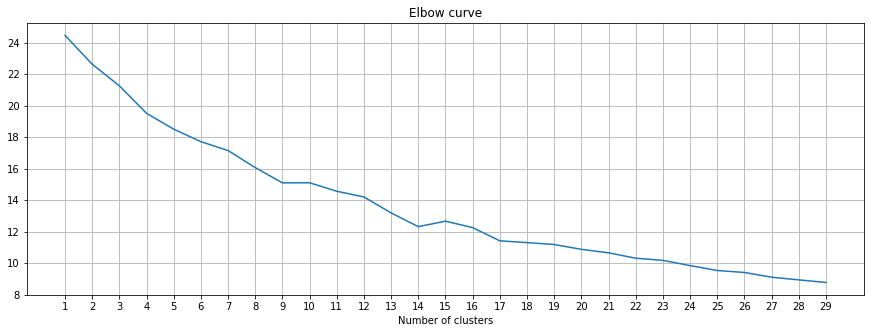

In [55]:
## looks like 10 is my optimum
fig = plt.figure(figsize=(15,5))
plt.plot(range(1,max_clusters), list_inertia)
plt.xticks(range(1,max_clusters))
plt.grid(True)
plt.xlabel('Number of clusters')
plt.title('Elbow curve')

In [56]:
# rerun clustering with 10 clusters
kmeans = KMeans(10, random_state=42).fit(phila_grouped_clust)

In [57]:
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([  1, 111,   2,   1,   2,   2,   1,   1,   1,  34]))

In [58]:
hoods_venues_sorted.insert(0,'Cluster Labels', kmeans.labels_)

In [59]:
#pd.get_dummies(df['text_general_code']).insert(0,df['Neighborhood'],)

In [60]:
hoods_venues_sorted.head(2)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,9,ACADEMY_GARDENS,Golf Course,Liquor Store,Gym / Fitness Center,Zoo Exhibit,Flower Shop,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Flea Market
1,1,AIRPORT,Airport Lounge,Currency Exchange,Airport Service,Bagel Shop,Newsstand,Electronics Store,Duty-free Shop,Donut Shop,Coffee Shop,Business Service


## Now work on Crime data

In [61]:
df_clust = pd.concat([df['Neighborhood'],pd.get_dummies(df['text_general_code'])], axis=1)

In [62]:
# prepare for clustering:

df_clust_group = df_clust.groupby('Neighborhood').mean().reset_index()

In [63]:
df_clust_input = df_clust_group.drop(columns=['Neighborhood'])

In [64]:
# run clustering

max_clusters = 30
list_inertia = []

for n_clusters in range(1,max_clusters):
    kmeans_crime = KMeans(n_clusters, random_state=42).fit(df_clust_input)
    list_inertia.append(kmeans_crime.inertia_)

Text(0.5, 1.0, 'Elbow curve')

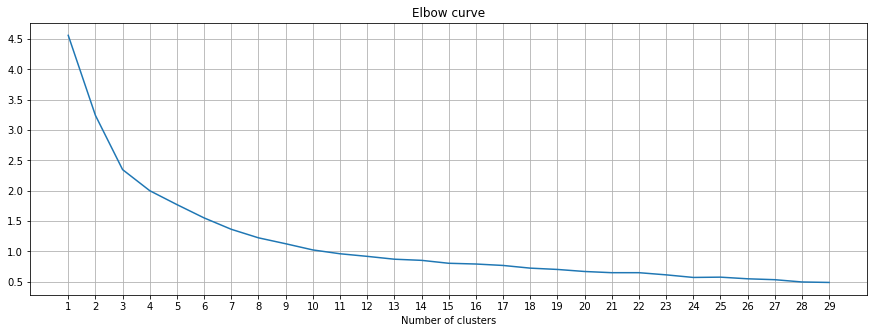

In [65]:
fig = plt.figure(figsize=(15,5))
plt.plot(range(1,max_clusters), list_inertia)
plt.xticks(range(1,max_clusters))
plt.grid(True)
plt.xlabel('Number of clusters')
plt.title('Elbow curve')


## same 9-10 clusters optimum

In [66]:
# rerun with 10 clusters

kmeans_crime = KMeans(10, random_state=42).fit(df_clust_input)

In [67]:
# and add cluster back to dataset

df_clust_group.insert(0,'Cluster Labels', kmeans_crime.labels_)

In [68]:
## insert mostly occured crime per Neighboorhood
num_top_crimes = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_crimes):
    try:
        columns.append('{}{} Most Common Crime'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Crime'.format(ind+1))

# create a new dataframe
crimes_sorted = pd.DataFrame(columns=columns)
crimes_sorted['Neighborhood'] = df_clust_group['Neighborhood']

for ind in np.arange(df_clust_group.shape[0]):
    crimes_sorted.iloc[ind, 1:] = return_most_common_records(df_clust_input.iloc[ind, :], num_top_crimes)

crimes_sorted.insert(0,'Cluster',kmeans_crime.labels_)    
crimes_sorted.head()

,Cluster,Neighborhood,1st Most Common Crime,2nd Most Common Crime,3rd Most Common Crime,4th Most Common Crime,5th Most Common Crime,6th Most Common Crime,7th Most Common Crime,8th Most Common Crime,9th Most Common Crime,10th Most Common Crime
0,6,ACADEMY_GARDENS,Other Assaults,Theft from Vehicle,All Other Offenses,Vandalism/Criminal Mischief,Thefts,Fraud,Burglary Residential,DRIVING UNDER THE INFLUENCE,Aggravated Assault No Firearm,Robbery No Firearm
1,1,AIRPORT,Thefts,Fraud,Theft from Vehicle,Other Assaults,Embezzlement,Vandalism/Criminal Mischief,All Other Offenses,Motor Vehicle Theft,Disorderly Conduct,Narcotic / Drug Law Violations
2,7,ALLEGHENY_WEST,Other Assaults,All Other Offenses,Vandalism/Criminal Mischief,Thefts,Narcotic / Drug Law Violations,Fraud,Theft from Vehicle,Aggravated Assault No Firearm,Burglary Residential,DRIVING UNDER THE INFLUENCE
3,4,ANDORRA,Thefts,Theft from Vehicle,All Other Offenses,Fraud,Other Assaults,Vandalism/Criminal Mischief,Burglary Residential,Burglary Non-Residential,Aggravated Assault No Firearm,Embezzlement
4,6,ASTON_WOODBRIDGE,Other Assaults,Vandalism/Criminal Mischief,Theft from Vehicle,Fraud,All Other Offenses,Thefts,Burglary Residential,Aggravated Assault No Firearm,Motor Vehicle Theft,DRIVING UNDER THE INFLUENCE


In [69]:
crimes_sorted.shape, hoods_venues_sorted.shape

((159, 12), (156, 12))

In [70]:
## now see if there is any correlation between breakdowns of venues and types of crime

In [71]:
crimes_sorted.head(15)

,Cluster,Neighborhood,1st Most Common Crime,2nd Most Common Crime,3rd Most Common Crime,4th Most Common Crime,5th Most Common Crime,6th Most Common Crime,7th Most Common Crime,8th Most Common Crime,9th Most Common Crime,10th Most Common Crime
0,6,ACADEMY_GARDENS,Other Assaults,Theft from Vehicle,All Other Offenses,Vandalism/Criminal Mischief,Thefts,Fraud,Burglary Residential,DRIVING UNDER THE INFLUENCE,Aggravated Assault No Firearm,Robbery No Firearm
1,1,AIRPORT,Thefts,Fraud,Theft from Vehicle,Other Assaults,Embezzlement,Vandalism/Criminal Mischief,All Other Offenses,Motor Vehicle Theft,Disorderly Conduct,Narcotic / Drug Law Violations
2,7,ALLEGHENY_WEST,Other Assaults,All Other Offenses,Vandalism/Criminal Mischief,Thefts,Narcotic / Drug Law Violations,Fraud,Theft from Vehicle,Aggravated Assault No Firearm,Burglary Residential,DRIVING UNDER THE INFLUENCE
3,4,ANDORRA,Thefts,Theft from Vehicle,All Other Offenses,Fraud,Other Assaults,Vandalism/Criminal Mischief,Burglary Residential,Burglary Non-Residential,Aggravated Assault No Firearm,Embezzlement
4,6,ASTON_WOODBRIDGE,Other Assaults,Vandalism/Criminal Mischief,Theft from Vehicle,Fraud,All Other Offenses,Thefts,Burglary Residential,Aggravated Assault No Firearm,Motor Vehicle Theft,DRIVING UNDER THE INFLUENCE
5,7,BARTRAM_VILLAGE,Other Assaults,All Other Offenses,Vandalism/Criminal Mischief,Thefts,Aggravated Assault No Firearm,Theft from Vehicle,Burglary Residential,Narcotic / Drug Law Violations,Fraud,Motor Vehicle Theft
6,8,BELLA_VISTA,Thefts,Theft from Vehicle,Vandalism/Criminal Mischief,Other Assaults,All Other Offenses,Fraud,Burglary Residential,Motor Vehicle Theft,Robbery No Firearm,Burglary Non-Residential
7,5,BELMONT,All Other Offenses,Other Assaults,Narcotic / Drug Law Violations,Thefts,Vandalism/Criminal Mischief,Aggravated Assault No Firearm,Burglary Residential,Fraud,Theft from Vehicle,Prostitution and Commercialized Vice
8,7,BREWERYTOWN,All Other Offenses,Other Assaults,Vandalism/Criminal Mischief,Narcotic / Drug Law Violations,Thefts,Theft from Vehicle,Burglary Residential,Aggravated Assault No Firearm,Fraud,Robbery No Firearm
9,6,BRIDESBURG,Other Assaults,Vandalism/Criminal Mischief,All Other Offenses,Theft from Vehicle,Thefts,Fraud,Burglary Residential,Aggravated Assault No Firearm,Motor Vehicle Theft,Burglary Non-Residential


In [72]:
hoods_venues_sorted.head(15)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,9,ACADEMY_GARDENS,Golf Course,Liquor Store,Gym / Fitness Center,Zoo Exhibit,Flower Shop,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Flea Market
1,1,AIRPORT,Airport Lounge,Currency Exchange,Airport Service,Bagel Shop,Newsstand,Electronics Store,Duty-free Shop,Donut Shop,Coffee Shop,Business Service
2,9,ALLEGHENY_WEST,Intersection,Grocery Store,Pizza Place,Fast Food Restaurant,Bus Station,Deli / Bodega,IT Services,Ethiopian Restaurant,Food Truck,Food Court
3,1,ANDORRA,Playground,American Restaurant,Food & Drink Shop,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Flea Market,Flower Shop,Food
4,1,ASTON_WOODBRIDGE,Business Service,Miscellaneous Shop,Seafood Restaurant,Liquor Store,Forest,Food Truck,Fountain,Food Court,Food & Drink Shop,Farm
5,1,BARTRAM_VILLAGE,Print Shop,Garden,Platform,Deli / Bodega,Indian Restaurant,Filipino Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market
6,1,BELLA_VISTA,Vietnamese Restaurant,Mexican Restaurant,Italian Restaurant,Sandwich Place,Coffee Shop,Bar,Pizza Place,Pub,Bakery,Latin American Restaurant
7,1,BELMONT,Breakfast Spot,Bakery,Cosmetics Shop,Light Rail Station,Event Space,Caribbean Restaurant,Seafood Restaurant,Mobile Phone Shop,Discount Store,Forest
8,1,BREWERYTOWN,Café,Brewery,Liquor Store,Deli / Bodega,Discount Store,Pizza Place,Record Shop,Ethiopian Restaurant,Sandwich Place,Food Truck
9,9,BRIDESBURG,Pizza Place,Speakeasy,Sporting Goods Shop,Clothing Store,Gym / Fitness Center,Bus Station,Convenience Store,Pharmacy,Food & Drink Shop,Food Court


In [73]:
hoods_venues_sorted.to_csv('clustered_venues.csv')
crimes_sorted.to_csv('clustered_crimed.csv')

In [74]:
df_global = crimes_sorted.merge(how='left', right=hoods_venues_sorted, left_on='Neighborhood', right_on='Neighborhood')

In [75]:
df_global.rename(columns = {'Cluster':'Cluster_Crime','Cluster Labels':'Cluster_venues'}, inplace=True)
df_global['Cluster_venues'].dropna(inplace=True)

In [76]:
df_global['Cluster_venues'] = df_global['Cluster_venues'].astype('int').astype('str')

In [77]:
df_global.head(10)

,Cluster_Crime,Neighborhood,1st Most Common Crime,2nd Most Common Crime,3rd Most Common Crime,4th Most Common Crime,5th Most Common Crime,6th Most Common Crime,7th Most Common Crime,8th Most Common Crime,9th Most Common Crime,10th Most Common Crime,Cluster_venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,6,ACADEMY_GARDENS,Other Assaults,Theft from Vehicle,All Other Offenses,Vandalism/Criminal Mischief,Thefts,Fraud,Burglary Residential,DRIVING UNDER THE INFLUENCE,Aggravated Assault No Firearm,Robbery No Firearm,9,Golf Course,Liquor Store,Gym / Fitness Center,Zoo Exhibit,Flower Shop,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Flea Market
1,1,AIRPORT,Thefts,Fraud,Theft from Vehicle,Other Assaults,Embezzlement,Vandalism/Criminal Mischief,All Other Offenses,Motor Vehicle Theft,Disorderly Conduct,Narcotic / Drug Law Violations,1,Airport Lounge,Currency Exchange,Airport Service,Bagel Shop,Newsstand,Electronics Store,Duty-free Shop,Donut Shop,Coffee Shop,Business Service
2,7,ALLEGHENY_WEST,Other Assaults,All Other Offenses,Vandalism/Criminal Mischief,Thefts,Narcotic / Drug Law Violations,Fraud,Theft from Vehicle,Aggravated Assault No Firearm,Burglary Residential,DRIVING UNDER THE INFLUENCE,9,Intersection,Grocery Store,Pizza Place,Fast Food Restaurant,Bus Station,Deli / Bodega,IT Services,Ethiopian Restaurant,Food Truck,Food Court
3,4,ANDORRA,Thefts,Theft from Vehicle,All Other Offenses,Fraud,Other Assaults,Vandalism/Criminal Mischief,Burglary Residential,Burglary Non-Residential,Aggravated Assault No Firearm,Embezzlement,1,Playground,American Restaurant,Food & Drink Shop,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Flea Market,Flower Shop,Food
4,6,ASTON_WOODBRIDGE,Other Assaults,Vandalism/Criminal Mischief,Theft from Vehicle,Fraud,All Other Offenses,Thefts,Burglary Residential,Aggravated Assault No Firearm,Motor Vehicle Theft,DRIVING UNDER THE INFLUENCE,1,Business Service,Miscellaneous Shop,Seafood Restaurant,Liquor Store,Forest,Food Truck,Fountain,Food Court,Food & Drink Shop,Farm
5,7,BARTRAM_VILLAGE,Other Assaults,All Other Offenses,Vandalism/Criminal Mischief,Thefts,Aggravated Assault No Firearm,Theft from Vehicle,Burglary Residential,Narcotic / Drug Law Violations,Fraud,Motor Vehicle Theft,1,Print Shop,Garden,Platform,Deli / Bodega,Indian Restaurant,Filipino Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market
6,8,BELLA_VISTA,Thefts,Theft from Vehicle,Vandalism/Criminal Mischief,Other Assaults,All Other Offenses,Fraud,Burglary Residential,Motor Vehicle Theft,Robbery No Firearm,Burglary Non-Residential,1,Vietnamese Restaurant,Mexican Restaurant,Italian Restaurant,Sandwich Place,Coffee Shop,Bar,Pizza Place,Pub,Bakery,Latin American Restaurant
7,5,BELMONT,All Other Offenses,Other Assaults,Narcotic / Drug Law Violations,Thefts,Vandalism/Criminal Mischief,Aggravated Assault No Firearm,Burglary Residential,Fraud,Theft from Vehicle,Prostitution and Commercialized Vice,1,Breakfast Spot,Bakery,Cosmetics Shop,Light Rail Station,Event Space,Caribbean Restaurant,Seafood Restaurant,Mobile Phone Shop,Discount Store,Forest
8,7,BREWERYTOWN,All Other Offenses,Other Assaults,Vandalism/Criminal Mischief,Narcotic / Drug Law Violations,Thefts,Theft from Vehicle,Burglary Residential,Aggravated Assault No Firearm,Fraud,Robbery No Firearm,1,Café,Brewery,Liquor Store,Deli / Bodega,Discount Store,Pizza Place,Record Shop,Ethiopian Restaurant,Sandwich Place,Food Truck
9,6,BRIDESBURG,Other Assaults,Vandalism/Criminal Mischief,All Other Offenses,Theft from Vehicle,Thefts,Fraud,Burglary Residential,Aggravated Assault No Firearm,Motor Vehicle Theft,Burglary Non-Residential,9,Pizza Place,Speakeasy,Sporting Goods Shop,Clothing Store,Gym / Fitness Center,Bus Station,Convenience Store,Pharmacy,Food & Drink Shop,Food Court


In [78]:
df_global.groupby(['Cluster_Crime'])['Cluster_venues'].value_counts(normalize=True)

Cluster_Crime  Cluster_venues
0              1                 0.850000
               0                 0.050000
               2                 0.050000
               9                 0.050000
1              1                 1.000000
2              1                 0.500000
               4                 0.500000
3              9                 0.666667
               1                 0.333333
4              1                 0.692308
               9                 0.307692
5              1                 0.545455
               9                 0.272727
               2                 0.090909
               7                 0.090909
6              1                 0.657143
               9                 0.257143
               4                 0.028571
               5                 0.028571
               8                 0.028571
7              1                 0.675676
               9                 0.297297
               3                 0.027027
8   

In [80]:
df_global.groupby(['Cluster_venues'])['Cluster_Crime'].value_counts(normalize=True)

Cluster_venues  Cluster_Crime
0               0                1.000000
1               7                0.225225
                6                0.207207
                8                0.180180
                0                0.153153
                4                0.081081
                1                0.063063
                5                0.054054
                9                0.018018
                2                0.009009
                3                0.009009
2               0                0.500000
                5                0.500000
3               7                1.000000
4               2                0.500000
                6                0.500000
5               6                0.500000
                8                0.500000
6               8                1.000000
7               5                1.000000
8               6                1.000000
9               7                0.323529
                6                0.264706
    

In [85]:
df_global.head(2)

,Cluster_Crime,Neighborhood,1st Most Common Crime,2nd Most Common Crime,3rd Most Common Crime,4th Most Common Crime,5th Most Common Crime,6th Most Common Crime,7th Most Common Crime,8th Most Common Crime,9th Most Common Crime,10th Most Common Crime,Cluster_venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,6,ACADEMY_GARDENS,Other Assaults,Theft from Vehicle,All Other Offenses,Vandalism/Criminal Mischief,Thefts,Fraud,Burglary Residential,DRIVING UNDER THE INFLUENCE,Aggravated Assault No Firearm,Robbery No Firearm,9,Golf Course,Liquor Store,Gym / Fitness Center,Zoo Exhibit,Flower Shop,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Flea Market
1,1,AIRPORT,Thefts,Fraud,Theft from Vehicle,Other Assaults,Embezzlement,Vandalism/Criminal Mischief,All Other Offenses,Motor Vehicle Theft,Disorderly Conduct,Narcotic / Drug Law Violations,1,Airport Lounge,Currency Exchange,Airport Service,Bagel Shop,Newsstand,Electronics Store,Duty-free Shop,Donut Shop,Coffee Shop,Business Service


## Conclusion

<p> Clearly, there are some dependencies among different neighborhoods and crime types.
For example neighborhoods clusters under 0,3 and 6 cluster only have crimes clustered 0,7 and 8 respectively. 

Some neighborhoods (cluster 2,4,5) showed predominant crime type (crime clusters 5,6), while roughly half of neighborhood clusters had no clear dominant clustering in crime.

</p>

Let’s try to determine if there are any similarities in clusters and whether we can spot any trends. Again, we will focus only on Neighborhood clusters that only have 1 or 2 predominant crime types (0,3,6) in it, ignoring neighborhoods with all sort of crimes.
Crime cluster 0 is a cluster with predominant all other offences and thefts from vehicles. Then Thefts, Vandalism/Fraud are trailing behind. While all of this is not really great, still it is much more “safer” than Cluster crime 7 for example, where “All other assaults” are taking 1 and the second most frequently happening place.

Let’s see if we draw any conclusions: Neighborhood cluster 0 which draws so many “light” crimes is a cluster where many service establishments are located:  Home Service/Vintage Store/Barbershop/Zoo Exhibit – all nonfood places with some exceptions.  Accordingly, these spots with mass gatherings, though not as social as eating/drinking draw many “light crimes”.  On the contrary, Neighborhood cluster 6 is more of “eatery” style borough with Thai/Fast Food/Filipino restaurants.  It looks like that these (not necessary these specific types of restaurants, but more like general places where people can get food and drinks) – tend to attract more violent type of crimes.

Of course, it is not a  final conclusion and many other steps can be recommended to improve the accuracy (specifically on the crimes side, as there are too many “Other” types of crimes.) Still, I think as a working hypothesis that there is a working correlation between amount of eateries/bars and number of “medium and more serious than medium” crimes. 


In [91]:
hoods_venues_sorted[hoods_venues_sorted['Cluster Labels'] == 0]

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
41,0,FOX_CHASE,Home Service,Thrift / Vintage Store,Sandwich Place,Salon / Barbershop,Zoo Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field


In [101]:
hoods_venues_sorted[hoods_venues_sorted['Cluster Labels'] == 6]

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
106,6,PENNYPACK,Thai Restaurant,Zoo Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Flea Market,Flower Shop,Food


In [103]:
hoods_venues_sorted[hoods_venues_sorted['Cluster Labels'] == 6]

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
106,6,PENNYPACK,Thai Restaurant,Zoo Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Flea Market,Flower Shop,Food


In [99]:
crimes_sorted[crimes_sorted['Cluster'] == 8]

,Cluster,Neighborhood,1st Most Common Crime,2nd Most Common Crime,3rd Most Common Crime,4th Most Common Crime,5th Most Common Crime,6th Most Common Crime,7th Most Common Crime,8th Most Common Crime,9th Most Common Crime,10th Most Common Crime
6,8,BELLA_VISTA,Thefts,Theft from Vehicle,Vandalism/Criminal Mischief,Other Assaults,All Other Offenses,Fraud,Burglary Residential,Motor Vehicle Theft,Robbery No Firearm,Burglary Non-Residential
12,8,BYBERRY,Theft from Vehicle,Thefts,Vandalism/Criminal Mischief,Other Assaults,All Other Offenses,Burglary Non-Residential,DRIVING UNDER THE INFLUENCE,Fraud,Embezzlement,Motor Vehicle Theft
18,8,CHESTNUT_HILL,Theft from Vehicle,Thefts,Fraud,Other Assaults,Burglary Residential,Vandalism/Criminal Mischief,All Other Offenses,Burglary Non-Residential,Robbery No Firearm,Motor Vehicle Theft
23,8,CRESTMONT_FARMS,Thefts,Other Assaults,Theft from Vehicle,All Other Offenses,Burglary Residential,Vandalism/Criminal Mischief,Fraud,Aggravated Assault No Firearm,Motor Vehicle Theft,Narcotic / Drug Law Violations
27,8,EASTWICK,Theft from Vehicle,Thefts,Other Assaults,Vandalism/Criminal Mischief,All Other Offenses,Fraud,Motor Vehicle Theft,Burglary Residential,Burglary Non-Residential,DRIVING UNDER THE INFLUENCE
28,8,EAST_FALLS,Theft from Vehicle,Vandalism/Criminal Mischief,Thefts,Other Assaults,Fraud,Burglary Residential,All Other Offenses,Motor Vehicle Theft,DRIVING UNDER THE INFLUENCE,Aggravated Assault No Firearm
33,8,EAST_PASSYUNK,Thefts,All Other Offenses,Other Assaults,Theft from Vehicle,Vandalism/Criminal Mischief,Fraud,Robbery No Firearm,Burglary Residential,Aggravated Assault No Firearm,Narcotic / Drug Law Violations
37,8,FAIRMOUNT,Theft from Vehicle,Vandalism/Criminal Mischief,Thefts,All Other Offenses,Other Assaults,Fraud,Burglary Residential,Motor Vehicle Theft,Robbery Firearm,Robbery No Firearm
40,8,FISHTOWN,Thefts,Theft from Vehicle,All Other Offenses,Vandalism/Criminal Mischief,Other Assaults,Burglary Residential,Fraud,Motor Vehicle Theft,DRIVING UNDER THE INFLUENCE,Aggravated Assault No Firearm
41,8,FITLER_SQUARE,Theft from Vehicle,Thefts,Vandalism/Criminal Mischief,All Other Offenses,Fraud,Burglary Residential,Other Assaults,Robbery No Firearm,Motor Vehicle Theft,Robbery Firearm
